In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os
from skimage.segmentation import chan_vese
import numpy as np
import PIL 
from PIL import Image 

# Display
# from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
import my_functions as mf

In [4]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [5]:
data_dir = 'datasetsSARS-COV-2 Ct-Scan-seg_join'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3356 files belonging to 2 classes.
Using 2685 files for training.
Found 3356 files belonging to 2 classes.
Using 671 files for validation.


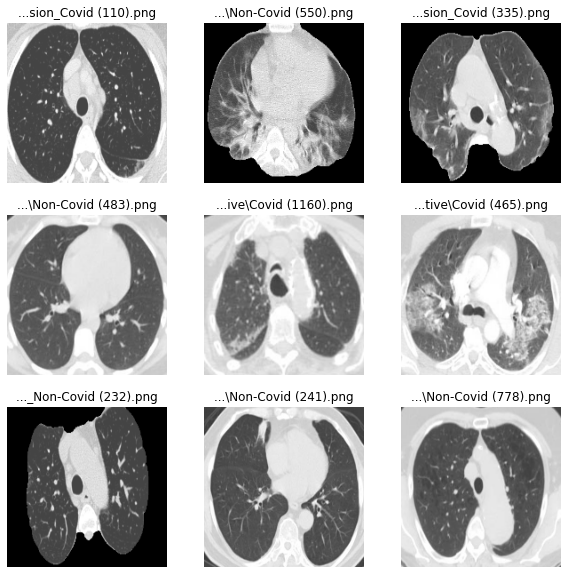

In [6]:
mf.check_dataset(train_ds)

## Model architecture

In [7]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1)
    ]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
last_layer_base_model = mf.find_last_layer(base_model)
# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(last_layer_base_model.output)

# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(x)

# x = keras.layers.MaxPool2D()()

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_base_model.output)

x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

### First train: Freezing base model

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

epochs = 100
base_model.trainable = False
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/100
84/84 [==============================] - 31s 208ms/step - loss: 0.7771 - accuracy: 0.5456 - val_loss: 0.6543 - val_accuracy: 0.5931
Epoch 2/100
84/84 [==============================] - 11s 135ms/step - loss: 0.6549 - accuracy: 0.5926 - val_loss: 0.5953 - val_accuracy: 0.7347
Epoch 3/100
84/84 [==============================] - 11s 136ms/step - loss: 0.6301 - accuracy: 0.6507 - val_loss: 0.5727 - val_accuracy: 0.7303
Epoch 4/100
84/84 [==============================] - 11s 136ms/step - loss: 0.5997 - accuracy: 0.6737 - val_loss: 0.5177 - val_accuracy: 0.7645
Epoch 5/100
84/84 [==============================] - 12s 139ms/step - loss: 0.5801 - accuracy: 0.6939 - val_loss: 0.5187 - val_accuracy: 0.7645
Epoch 6/100
84/84 [==============================] - 11s 137ms/step - loss: 0.5691 - accuracy: 0.7006 - val_loss: 0.4896 - val_accuracy: 0.7630
Epoch 7/100
84/84 [==============================] - 11s 137ms/step - loss: 0.5884 - accuracy: 0.6767 - val_loss: 0.4760 - val_accuracy:

In [9]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\Covid (100).png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.9748982]], dtype=float32)

In [10]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-negative\\Non-Covid (100).png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.19363259]], dtype=float32)

In [15]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
epochs = 100
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

run_modeldir = mf.get_model_dir()
model.save(run_modeldir)

Epoch 1/100


KeyboardInterrupt: 

In [16]:
model.save(run_logdir)

INFO:tensorflow:Assets written to: .\my_logs\run_2021_11_01-20_46_49\assets


In [18]:
model = keras.models.load_model("my_logs\\run_2021_11_01-20_46_49")

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

In [23]:
import my_functions as mf

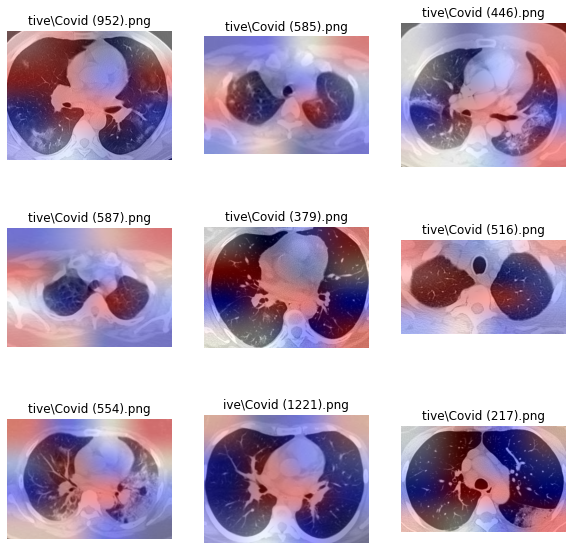

In [40]:
mf.test_grad_cam_in_path(
      model,
      "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\",
      image_size,
      grad_colormap="seismic",
      original_image_colormap="grayscale",
      last_layer_grad_cam='conv_7b_ac')

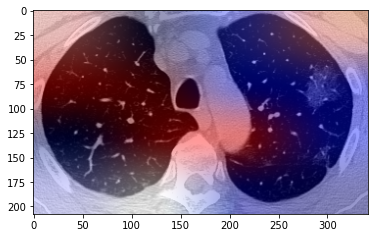

In [41]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\Covid (305).png"
superimposed_img = mf.superimpose_gradcam( 
   current_model=model, 
   img_path=img_path,
   image_size=image_size,
   grad_colormap="seismic",
   original_image_colormap="grayscale",
   last_layer_grad_cam='conv_7b_ac')

plt.imshow(superimposed_img)

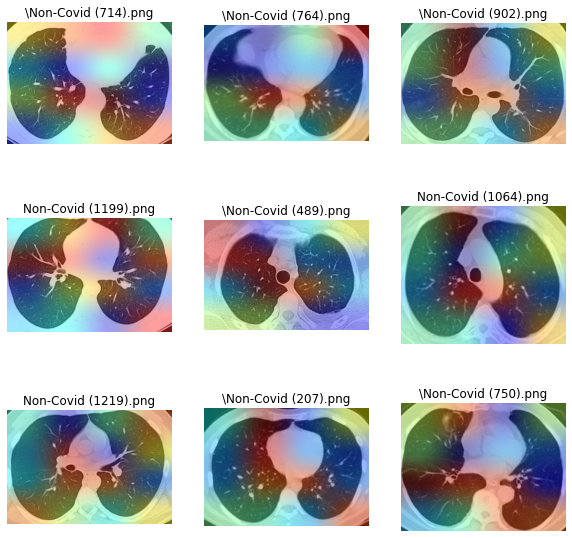

In [39]:
mf.test_grad_cam_in_path(
      model,
      "datasetsSARS-COV-2 Ct-Scan\\COVID-negative\\",
      image_size,
      grad_colormap="jet",
      original_image_colormap="grayscale",
      last_layer_grad_cam='conv_7b_ac')